In [36]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.morphology import remove_small_holes, area_opening, skeletonize
import pandas as pd
from matplotlib import rcParams


THRESHOLD = 120
MAX_PIXEL_VALUE = 255
MM2_CALIBRATION = 1000*(924)*1e-6  #largo*(diametro) de la cabecilla [µm^2 -> mm^2]

COLOR = 'black'
plt.style.use("default")
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['figure.figsize'] = (28, 18)
rcParams['figure.titlesize'] = 20
rcParams['figure.dpi'] = 50
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = 'lightgray'
rcParams['legend.fontsize'] = 25
rcParams['axes.titlesize'] = 60
rcParams['axes.labelsize'] = 50
rcParams['ytick.labelsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR
rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

### funciones que se usan

In [54]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY'):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, THRESHOLD, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def find(frame):
    y, x = np.where(frame==0)
    x_head = np.min(x)
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()

            if ret:
                frame = cortar(frame, limites)
                frame_bn = binarize(gris(frame))
                mask = frame_bn>0
                frame_bn = remove_small_holes(mask,10)*255
                try:
                    x, y, x_head, y_head = find(frame_bn)
                    pos_x.append(x_head)
                    pos_y.append(y_head)
                    if SHOW:
                        frame[y, x] = [0, 255, 0]
                        frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                        cv.imshow('frame', frame)
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

def guillotina(frame, PRUEBA=False, nombre='DECAPITADO'):
    y, x = np.where(frame<=130)
    frame[y, x] = np.max(frame)
    frame -= np.min(frame)
    frame = (frame/np.max(frame))*255
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', frame)
    return frame

def binarize_TAIL(frame, PRUEBA=False, nombre='BINARY_TAIL'):
    _, im_binary = cv.threshold(frame, THRESHOLD, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    arr = im_binary > 0
    im_binary = remove_small_holes(arr)*255
    im_binary = area_opening(im_binary, 200)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255
    sk = skeletonize(arr)*255
    y, x = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return x, y

def track_TAIL(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                frame = cortar(frame, limites)
                frame_bn = binarize_TAIL(guillotina(gris(frame)))
                try:
                    x, y = skeleton(frame_bn)
                    frame[y, x] = [0, 0, 255]
                    cv.imshow('frame', frame)
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
                
        return np.array(tiempo)

### Prueba de una sola imagen

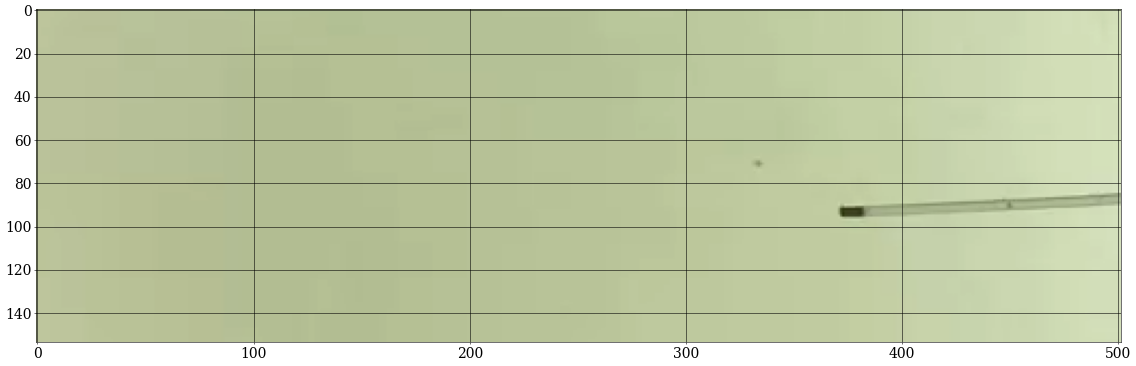

In [11]:
im = cv.imread('test-image.png')
plt.imshow(im)

#### Probando calibración en una sola imagen

El número de pixeles oscuros es: 51
Por lo tanto el mm2 por píxel es: 0.018117647058823527


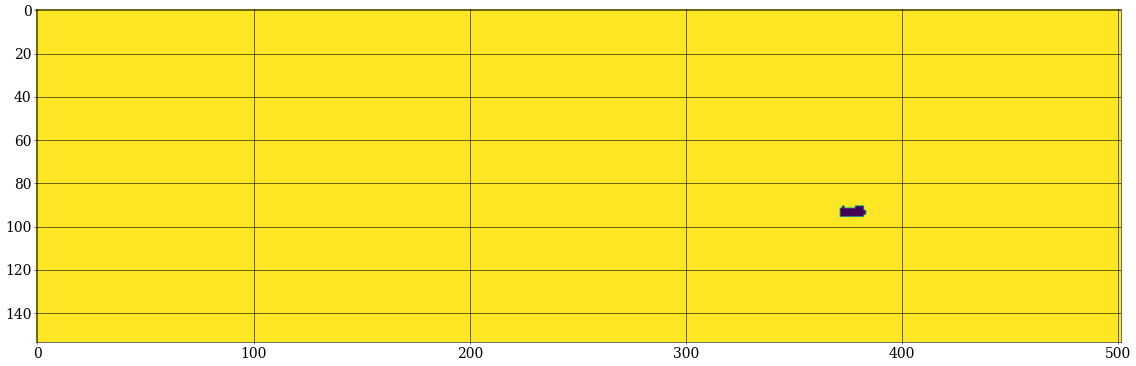

In [37]:
im_gray = gris(im)
im_binary = binarize(im_gray)
mask = im_binary>0
im_binary = remove_small_holes(mask,10)*255
plt.imshow(im_binary)
number_of_pixels = im_binary[im_binary==0].size
print(f'El número de pixeles oscuros es: {number_of_pixels}')

mm2_per_px = MM2_CALIBRATION / number_of_pixels
print(f'Por lo tanto el mm2 por píxel es: {mm2_per_px}')

383

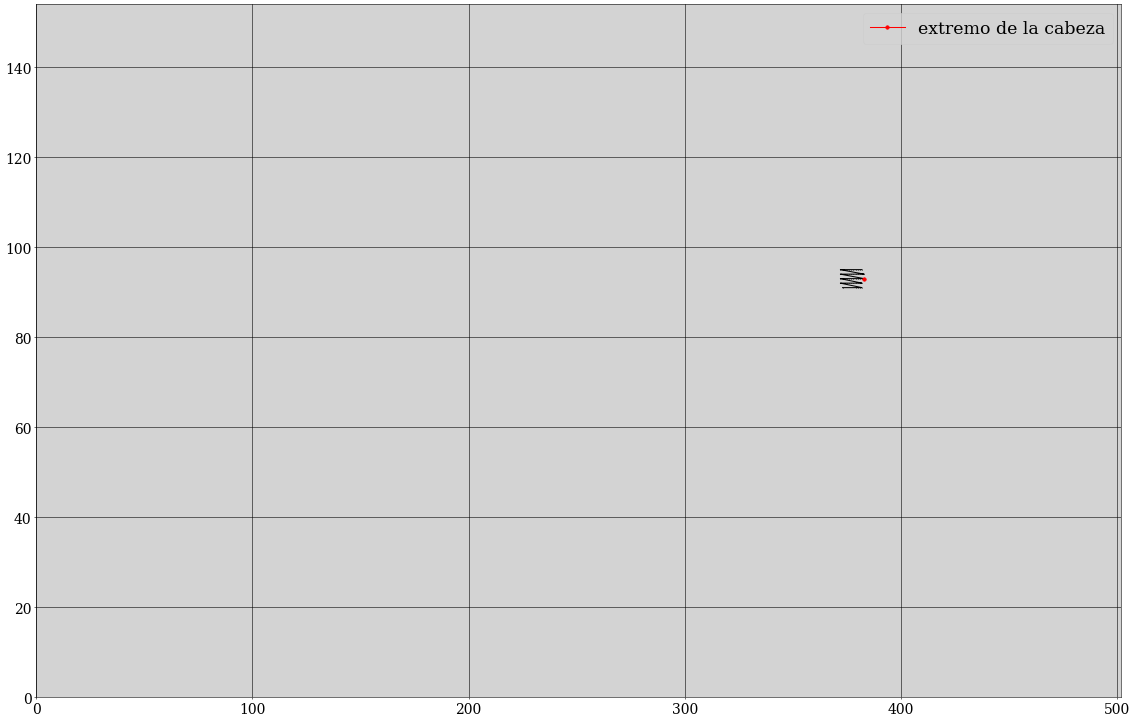

In [40]:
y, x = np.where(im_binary==0)
x_head = np.max(x)
filas_2 = np.unique(y)
y_head = int(np.mean(filas_2))

fig, ax = plt.subplots()
ax.set_xlim(0, len(im_binary[0]))
ax.set_ylim(0, len(im_binary))

ax.plot(x, y, color = 'k', marker='.', markersize=0.5)
ax.plot(x_head, y_head, color = 'r', marker='.', markersize=10, label='extremo de la cabeza')
ax.legend()
x_head

### Pruebas de un solo video

In [5]:
# abro y analizo video
video = cv.VideoCapture('videos/ECO20-45mm-2,00Vpp-8Hz.mp4')
#lim = [319, 1009, 205, 505]
lim = [319, 950, 250, 505]
t,x,y = tracker(video, lim, SHOW=True)

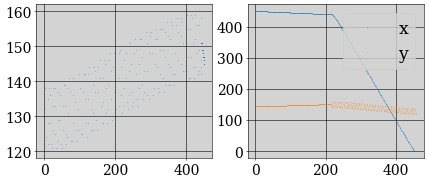

In [6]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(x, y, '.', markersize=0.5)

ax2.plot(t[:len(x)], x, '.', markersize=0.5,label='x')
ax2.plot(t[:len(x)], y, '.', markersize=0.5, label='y')
ax2.legend()

In [90]:
im = cv.imread('Camo Snapshot 2024-05-17 12-04-24 - 10Hz.jpg')
im_cut = cortar(im, limites=lim)
im_gray = gris(im_cut)
im_decap = guillotina(im_gray, PRUEBA=True)
im_binary = binarize_TAIL(im_decap, P496mVppRUEBA=True)
im_sk = skeleton(im_binary, PRUEBA=True)

In [4]:
video = cv.VideoCapture('videos/ECO20-45mm-1,00Vpp-2Hz.mp4')
lim = [319, 950, 250, 505]
t = track_TAIL(video, lim)

### Chequeo de calibración en un solo video

In [45]:
vs = cv.VideoCapture('videos/ECO20-45mm-1,50Vpp-7,33Hz.mp4')

Promedio de calibración: 56.73619309982947 pm 4.445343325478998 px/mm^2


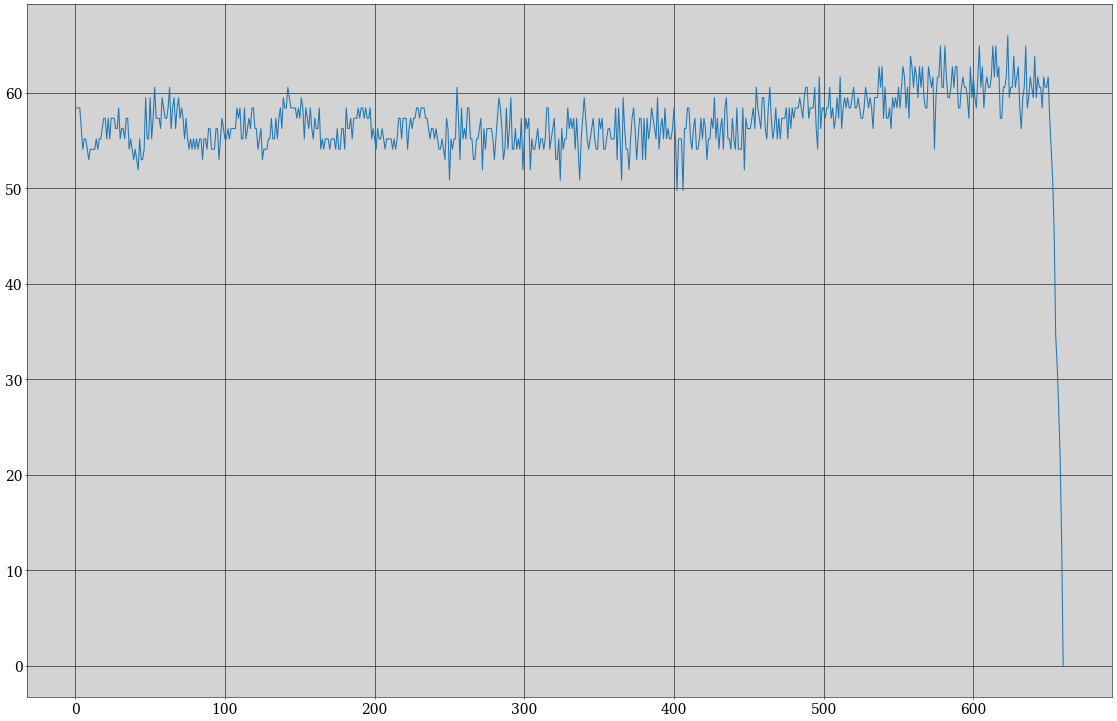

In [52]:
vs = cv.VideoCapture('videos/ECO20-45mm-1,50Vpp-7,33Hz.mp4')
#lim = [319, 1009, 205, 505]
lim = [319, 950, 250, 505]

# Crea las listas vacias que van a ser nuestras mediciones
pos_x = []
pos_y = []
calibracion = []

frame_count = vs.get(7)
tiempo = [f for f in range(1, int(frame_count))]

while(vs.isOpened()):
    ret, frame = vs.read()

    if ret:
        frame = cortar(frame, lim)
        frame_bn = binarize(gris(frame))
        mask = frame_bn>0
        frame_bn = remove_small_holes(mask,10)*255
        number_of_pixels = frame_bn[frame_bn==0].size
        px_per_mm2 = number_of_pixels / MM2_CALIBRATION #number_of_pixels puede ser 0 entonces tomamos px_per_mm2
        calibracion.append(px_per_mm2)
        try:
            x, y, x_head, y_head = find(frame_bn)
            pos_x.append(x_head)
            pos_y.append(y_head)
            if True:
                frame[y, x] = [0, 255, 0]
                frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                cv.imshow('frame', frame)
        except:
            break
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cv.destroyAllWindows()
plt.plot(tiempo[:len(calibracion)],calibracion)

print(f'Promedio de calibración: {np.mean(calibracion)} pm {np.std(calibracion)} px/mm^2')

### Maquina de hacer datos de (x,y,t) para cada video

In [55]:
import os

for filename in os.listdir('videos'):
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    video = cv.VideoCapture('videos/'+filename)
    lim = [319, 950, 250, 505] #[xleft, xright, ytop, ydown]
    t,x,y = tracker(video, lim, SHOW=False)

    # Guardo los datos
    #pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).to_csv(f'ECO20-45mm/{v}-{f}.csv')
    
    # # Graficos de debuggeo
    # fig, [ax1, ax2] = plt.subplots(1, 2)

    # fig.suptitle(f'{v} ; {f}')
    
    # ax1.plot(x, y, '.')
    # ax2.plot(t[:len(x)], x, '.',label='x')
    # ax2.plot(t[:len(x)], y, '.', label='y')
    # ax2.legend()